# Import packages and set up enviroment

*   List item
*   List item



In [1]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

In [ ]:
!pip3 install --quiet umap-learn
!pip3 install --quiet anndata
!pip3 install --quiet scanpy
!pip3 install --quiet sklearn
!pip3 install --quiet leidenalg
!pip3 install --quiet scvi-tools
!pip3 install --quiet python-louvain
!pip3 install celltypist


In [1]:
import anndata, os, numpy as np, scanpy as sc, sklearn
import celltypist
from celltypist import models
from celltypist import Model, classifier

/home/Disk14T/xly/anaconda3/envs/xly/lib/python3.12/site-packages/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/home/Disk14T/xly/anaconda3/envs/xly/lib/python3.12/site-packages/anndata/utils.py:429: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/home/Disk14T/xly/anaconda3/envs/xly/lib/python3.12/site-packages/anndata/utils.py:429: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
/home/Disk14T/xly/anaconda3/envs/xly/lib/python3.12/site-packages/anndata/utils.py:429: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/home/Disk14T/xly/anaconda3/envs/xly/lib/python3.12/site-packages/anndata/utils.py:429: FutureWarn

In [3]:
PATH = "/content/drive/MyDrive/MultiVI//MultiVI-Datasets/Dogma-seq/"
adata = anndata.read("../Data/dogma_all_genes_cells.h5ad.gz")
adata.var_names_make_unique()
#adata = adata[adata.obs.sample_type == "DIG_CTRL"]
min_cells = int(adata.shape[0] * 0.01)
sc.pp.filter_genes(adata, min_cells=min_cells)
adata.var['modality'] = adata.var.Type.copy()
adata

/home/Disk14T/xly/anaconda3/envs/xly/lib/python3.12/site-packages/anndata/__init__.py:52: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(
/home/Disk14T/xly/anaconda3/envs/xly/lib/python3.12/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 36445 × 114801
    obs: 'idx_rna', 'idx_atac', 'sample_type', 'batch', 'stim', 'protein_MS1', 'rna_MS1', 'peaks.MS', 'predicted.celltype.l1', 'idx_adt'
    var: 'GeneID', 'Gene Symbol', 'Type', 'chr', 'start', 'end', 'len', 'star', 'idx', 'n_cells', 'modality'
    obsm: 'protein_expression'

In [7]:
models.download_models(force_update = True)
model = models.Model.load(model = 'Immune_All_Low.pkl')
model.features

📜 Retrieving model list from server https://celltypist.cog.sanger.ac.uk/models/models.json
📚 Total models in list: 54
📂 Storing models in /home/xly/.celltypist/data/models
💾 Downloading model [1/54]: Immune_All_Low.pkl
💾 Downloading model [2/54]: Immune_All_High.pkl
💾 Downloading model [3/54]: Adult_COVID19_PBMC.pkl
💾 Downloading model [4/54]: Adult_CynomolgusMacaque_Hippocampus.pkl
💾 Downloading model [5/54]: Adult_Human_MTG.pkl
💾 Downloading model [6/54]: Adult_Human_PancreaticIslet.pkl
💾 Downloading model [7/54]: Adult_Human_PrefrontalCortex.pkl
💾 Downloading model [8/54]: Adult_Human_Skin.pkl
💾 Downloading model [9/54]: Adult_Human_Vascular.pkl
💾 Downloading model [10/54]: Adult_Mouse_Gut.pkl
💾 Downloading model [11/54]: Adult_Mouse_OlfactoryBulb.pkl
💾 Downloading model [12/54]: Adult_Pig_Hippocampus.pkl
💾 Downloading model [13/54]: Adult_RhesusMacaque_Hippocampus.pkl
💾 Downloading model [14/54]: Autopsy_COVID19_Lung.pkl
💾 Downloading model [15/54]: COVID19_HumanChallenge_Blood.pkl

array(['A1BG', 'A2M', 'A2M-AS1', ..., 'ZSWIM6', 'ZWINT', 'ZYX'],
      dtype=object)

In [4]:
adata_gex = adata[:, adata.var.modality=="Gene Expression"]
ad = anndata.AnnData(X=adata_gex.X, obs=adata.obs)
ad.var.index = adata_gex.var['Gene Symbol'].to_numpy()
ad.var_names_make_unique()
sc.pp.filter_cells(ad, min_genes=100)
sc.pp.filter_genes(ad, min_cells=100)
sc.pp.filter_cells(ad, min_genes=1)
sc.pp.normalize_total(ad, target_sum=1e4)
sc.pp.log1p(ad)

In [8]:
lr_classifier = model if isinstance(model, Model) else Model.load(model)
lr_classifier.features
clf = classifier.Classifier(filename = ad, model = lr_classifier, transpose = False, gene_file = None, cell_file = None)
predictions = clf.celltype()
over_clustering = clf.over_cluster()
predictions.adata = clf.adata
predictions_majorityvote = classifier.Classifier.majority_vote(predictions, over_clustering)

🔬 Input data has 36176 cells and 12199 genes


🔗 Matching reference genes in the model
🧬 3848 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 15
🗳️ Majority voting the predictions
✅ Majority voting done!


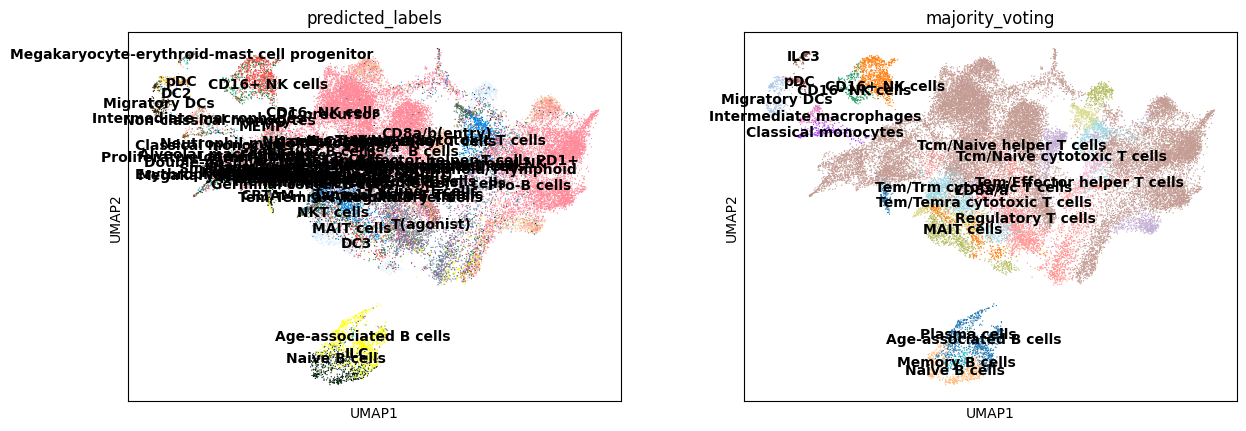

In [9]:
ad_annotated = predictions_majorityvote.to_adata()
idx = np.array([np.where(adata.obs.index == ad.obs.index[i])[0] for i in np.arange(ad.shape[0])]).squeeze()
sc.tl.umap(ad_annotated)
sc.pl.umap(ad_annotated, color = ['predicted_labels', 'majority_voting'], legend_loc = 'on data')


In [10]:
ad_annotated

AnnData object with n_obs × n_vars = 36176 × 12199
    obs: 'idx_rna', 'idx_atac', 'sample_type', 'batch', 'stim', 'protein_MS1', 'rna_MS1', 'peaks.MS', 'predicted.celltype.l1', 'idx_adt', 'n_genes', 'predicted_labels', 'over_clustering', 'majority_voting', 'conf_score'
    var: 'n_cells'
    uns: 'log1p', 'neighbors', 'over_clustering', 'umap', 'predicted_labels_colors', 'majority_voting_colors'
    obsm: 'X_pca', 'X_umap'
    obsp: 'connectivities', 'distances'

In [ ]:
adata.obs['majority_voting'] = ad_annotated.obs.majority_voting
adata.write("../Data/dogma_all_genes_cells_annotated.h5ad.gz", compression='gzip')

In [12]:
adata

AnnData object with n_obs × n_vars = 36445 × 114801
    obs: 'idx_rna', 'idx_atac', 'sample_type', 'batch', 'stim', 'protein_MS1', 'rna_MS1', 'peaks.MS', 'predicted.celltype.l1', 'idx_adt', 'majority_voting'
    var: 'GeneID', 'Gene Symbol', 'Type', 'chr', 'start', 'end', 'len', 'star', 'idx', 'n_cells', 'modality'
    obsm: 'protein_expression'

In [ ]:
adata.obs['modality'] = 'unassigned'  # 初始化标签

# 获取两个分组列的组合
group_combos = adata.obs.groupby(['majority_voting', 'sample_type']).groups
retained_list = []  # 收集所有组的 retained

for (majority_voting, sample_type), indices in group_combos.items():
    group_cells = adata[indices]
    n_cells = group_cells.n_obs

    if n_cells < 4:
        continue  # 太小的组就跳过

    # Step 1: 随机选2/3留下
    n_keep = int(n_cells * 1 / 3)
    retained_idx = np.random.choice(group_cells.obs_names, n_keep, replace=False)
    retained = adata[retained_idx].copy()

    # Step 2: 拆成四组
    n_split = len(retained) // 4
    shuffled_idx = np.random.permutation(retained.obs_names)

    idx_exp_acc = shuffled_idx[:n_split]
    idx_acc_pro = shuffled_idx[n_split:2*n_split]
    idx_exp_pro = shuffled_idx[2*n_split:3*n_split]
    idx_paired  = shuffled_idx[3*n_split:]

    retained.obs.loc[idx_exp_acc, 'modality'] = 'exp+acc'
    retained.obs.loc[idx_acc_pro, 'modality'] = 'acc+pro'
    retained.obs.loc[idx_exp_pro, 'modality'] = 'exp+pro'
    retained.obs.loc[idx_paired, 'modality'] = 'paired'

    retained_list.append(retained)

# Step 3: 合并所有组
adata_retained = anndata.concat(retained_list, axis=0, join='outer', merge='same')

In [ ]:
adata_retained[adata_retained.obs['modality'] == 'exp+pro',adata_retained.var['modality'] == 'Peaks'].X = 0
adata_retained[adata_retained.obs['modality'] == 'acc+pro',adata_retained.var['modality'] == 'Gene Expression'].X = 0

/home/Disk14T/xly/anaconda3/envs/xly/lib/python3.12/site-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


AttributeError: 'int' object has no attribute 'shape'

In [29]:
adata_retained.obsm['protein_expression'][adata_retained.obs['modality'] == 'exp+acc'] = 0

In [ ]:
adata_retained.write("../Data/dogma_all_genes_cells_75unpaired.h5ad.gz", compression='gzip')

... storing 'modality' as categorical


In [ ]:
adata2=anndata.read_h5ad("../Data/dogma_all_genes_cells_75unpaired.h5ad.gz")

adata = adata2.copy()  # 避免破坏原始数据

# 条件筛选：行（细胞）和列（特征）
cell_mask = adata.obs['modality'] == 'paired'

# 找出这些细胞的索引
cell_indices = np.where(cell_mask)[0]
np.random.shuffle(cell_indices)  # 打乱索引顺序

# 平均三分
n = len(cell_indices)
group1 = cell_indices[:n // 3]
group2 = cell_indices[n // 3: 2 * n // 3]
group3 = cell_indices[2 * n // 3:]

feature_mask1 = adata.var['modality'] == 'Gene Expression'
feature_mask2 = adata.var['modality'] == 'Peaks'
feature_indices1 = np.where(feature_mask1)[0]
feature_indices2 = np.where(feature_mask2)[0]

# 将对应位置的值设为 0
adata.X[np.ix_(group1, feature_indices1)] = 0
adata.X[np.ix_(group2, feature_indices2)] = 0
adata.obsm["protein_expression"].values[group3, :] = 0

adata.obs_names_make_unique()

group1_obs_names = adata.obs_names[group1]
adata.obs.loc[group1_obs_names, 'modality'] = 'acc+pro'
group2_obs_names = adata.obs_names[group2]
adata.obs.loc[group2_obs_names, 'modality'] = 'exp+pro'
group3_obs_names = adata.obs_names[group3]
adata.obs.loc[group3_obs_names, 'modality'] = 'exp+acc'
adata.write("../Data/dogma_all_genes_cells_2ineach.h5ad.gz", compression='gzip')

In [ ]:
adata2=anndata.read_h5ad("../Data/dogma_all_genes_cells_annotated.h5ad.gz")

adata = adata2.copy()  # 避免破坏原始数据
adata.obs['modality'] = 'unassigned'  # 初始化标签

# 获取两个分组列的组合
group_combos = adata.obs.groupby(['majority_voting', 'sample_type']).groups
retained_list = []  # 收集所有组的 retained

for (majority_voting, sample_type), indices in group_combos.items():
    group_cells = adata[indices]
    n_cells = group_cells.n_obs

    if n_cells < 7:
        continue  # 太小的组就跳过

    # Step 1: 随机选2/3留下
    n_keep = int(n_cells * 1 / 3)
    retained_idx = np.random.choice(group_cells.obs_names, n_keep, replace=False)
    retained = adata.copy()

    # Step 2: 拆成四组
    n_split = len(retained) // 7
    shuffled_idx = np.random.permutation(retained.obs_names)

    idx_exp_acc = shuffled_idx[:n_split]
    idx_acc_pro = shuffled_idx[n_split:2*n_split]
    idx_exp_pro = shuffled_idx[2*n_split:3*n_split]
    idx_exp = shuffled_idx[3*n_split:4*n_split]
    idx_acc = shuffled_idx[4*n_split:5*n_split]
    idx_pro = shuffled_idx[5*n_split:6*n_split]
    idx_paired  = shuffled_idx[6*n_split:]

    retained.obs.loc[idx_exp_acc, 'modality'] = 'exp+acc'
    retained.obs.loc[idx_acc_pro, 'modality'] = 'acc+pro'
    retained.obs.loc[idx_exp_pro, 'modality'] = 'exp+pro'
    retained.obs.loc[idx_exp, 'modality'] = 'exp'
    retained.obs.loc[idx_acc, 'modality'] = 'acc'
    retained.obs.loc[idx_pro, 'modality'] = 'pro'
    retained.obs.loc[idx_paired, 'modality'] = 'paired'

    retained_list.append(retained)

# Step 3: 合并所有组
adata_retained = anndata.concat(retained_list, axis=0, join='outer', merge='same')

adata_retained[adata_retained.obs['modality'] == 'exp+pro',adata_retained.var['modality'] == 'Peaks'].X = 0
adata_retained[adata_retained.obs['modality'] == 'acc+pro',adata_retained.var['modality'] == 'Gene Expression'].X = 0
adata_retained[adata_retained.obs['modality'] == 'exp+acc'].obsm["protein_expression"] = 0
adata_retained[adata_retained.obs['modality'] == 'exp', adata_retained.var['modality'] == 'Peaks'].X = 0
adata_retained[adata_retained.obs['modality'] == 'exp'].obsm["protein_expression"] = 0
adata_retained[adata_retained.obs['modality'] == 'acc', adata_retained.var['modality'] == 'Gene Expression'].X = 0
adata_retained[adata_retained.obs['modality'] == 'acc'].obsm["protein_expression"] = 0
adata_retained[adata_retained.obs['modality'] == 'pro', :].X = 0
adata_retained.write("../Data/dogma_all_genes_cells_all_comb.h5ad.gz", compression='gzip')